# Project Orange: IMDB reviews sentiment analysis

## Setup

Install all required dependencies in the current Jupyter kernel

In [430]:
import sys
!{sys.executable} -m pip install spacy pandas sklearn
!{sys.executable} -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [431]:
import pandas as pd
import re
import spacy
from spacy import displacy
from spacy.lang.en import English
from sklearn.model_selection import train_test_split

sp = spacy.load('en_core_web_sm')

### Import dataset

In [432]:
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("../data/IMDB Dataset.csv") 

# Keep the first 10 elements to reduce the load on cpu
data=data[:100]
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [433]:
#base rate, delete later
a=data[data["sentiment"]=="positive"].shape
b=data[data["sentiment"]=="negative"].shape
base_rate=max(a[0], b[0])/data.shape[0]
print("The base rate is "+ str(base_rate))

The base rate is 0.58


### Text to lowercase

In [434]:
def to_lower(this_review):
    this_review=this_review.lower()
    return this_review
    
#data['review'] = data['review'].map(to_lower)
#data.head()

### Remove HTML elements

In [435]:
REMOVE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def remove_html(review):
    return REMOVE_HTML.sub(" ", review) 

#data['cleaned_review'] = data['review'].map(remove_html)
#data.head()

### Identify and remove entities

In [436]:
def recognize_it(this_review):
    doc=sp(this_review)
    
    for i in doc.ents:
            i=str(i)
            this_review=this_review.replace(" "+i,"")
    return this_review

In [437]:
#data['IDcleaned_review'] = data['cleaned_review'].map(recognize_it)
#data.head()

### Lemmatization

In [438]:
# Implementing lemmatization
def lemmatize_it(this_review):
    filtered_sent=[]

    #  "nlp" Object is used to create documents with linguistic annotations.
    lem = sp(this_review)
    
   # finding lemma for each word
    for word in lem:
        filtered_sent.append(word.lemma_)
    return filtered_sent

In [439]:
#data['lemmatized_review'] = data['IDcleaned_review'].map(lemmatize_it)
#data.head()

### Tokenization (not used)

In [440]:
# "nlp" Object is used to create documents with linguistic annotations.
nlp = English()

def tokenize_review(this_review):
    my_doc = nlp(this_review)
    
    # Create list of word tokens
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
    return token_list

In [441]:
#data['tokenized_review'] = data['cleaned_review'].map(tokenize_review)
#data.head()

### Adapt spacy stopwords list to our topic

In [442]:
#print stopword list from spacy
spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)

remove_from_stopwordlist=["n't", "most", "much", "never", "no", "not", "nothing", "n‘t", "n’t", "really", "top", "very", "well"]
for word in spacy_stopwords:
    if word in remove_from_stopwordlist:
         spacy_stopwords.remove(word)

add_to_stopwords=['.', ',', '!', '?', ':', '&', '...', '(', ')','-', '/', '"', ';', '-PRON-', ' ']
for word in add_to_stopwords:
    spacy_stopwords.append(word)

###  Remove stopwords and punctuation

In [443]:
def eliminate_stopwords(this_review):
    
    filtered_sent=[]

    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = this_review
    
    # filtering stop words
    for word in doc:
        if word not in spacy_stopwords:
            filtered_sent.append(word)
    return filtered_sent
    

In [444]:
#data['stopcleaned_review'] = data['lemmatized_review'].map(eliminate_stopwords)
#data.head()

Do we do Bag of Words?
Do we do TF-IDF?

In [445]:
def MASTA_CLEAN(this_review):
    this_review=to_lower(this_review)
    this_review=remove_html(this_review)
    this_review=recognize_it(this_review)
    this_review=lemmatize_it(this_review)
    this_review=eliminate_stopwords(this_review)
    return this_review

In [446]:
data['mastacleaned_reviews'] = data['review'].map(MASTA_CLEAN)
data.head()

,review,sentiment,mastacleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,"[reviewer, mention, watch, oz, episode, hook, ..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, sit,..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, love, time, money, visually, stunning..."


### Splitting the dataset into training and test sets

In [447]:
X = data['review'] # the features we want to analyze, we can play with others too
y = data['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

#### Logistic Model

In [448]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
classifier = LogisticRegression(solver="lbfgs")

count_vector = CountVectorizer(tokenizer = MASTA_CLEAN, ngram_range = (1,2))

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function MASTA_CLEAN at 0x000002373B329488>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
         

#### Evaluating Logistic Regression (precision and recall are calculated for positive reviews)

In [449]:
predicted_train = pipe.predict(X_train)
predicted_test = pipe.predict(X_test)
# train accuracy
print("Train set accuracy: " + str(pipe.score(X_train, y_train)))
# test accuracy
print("Test set accuracy is: " + str(pipe.score(X_test, y_test)))
print("Train set precision: " + str(metrics.precision_score(y_train, predicted_train, pos_label="positive")))
print("Train set recall: " +  str(metrics.recall_score(y_train, predicted_train, pos_label="positive")))
print("Test set precision: " + str(metrics.precision_score(y_test, predicted_test, pos_label="positive")))
print("Test set recall: " + str(metrics.recall_score(y_test, predicted_test, pos_label="positive")))


Train set accuracy: 1.0
Test set accuracy is: 0.55
Train set precision: 1.0
Train set recall: 1.0
Test set precision: 1.0
Test set recall: 0.18181818181818182


Confusion matrix for test set, without normalization


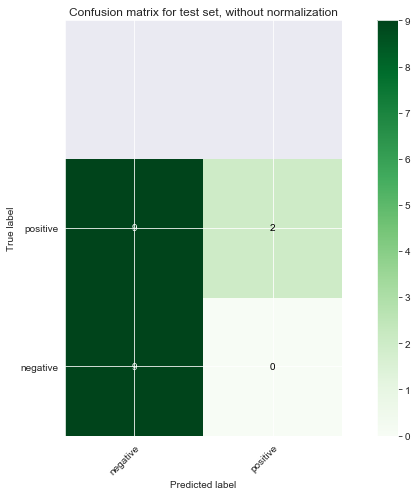

In [450]:
# confusion matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
from sklearn.metrics import confusion_matrix
log_reg = pipe
log_reg.fit(X_train,y_train)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix for test set, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix for test set, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(10,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.ylim([-0.5, 2.5])
    
    ax.xaxis.set_ticklabels(["negative", "positive"])
    ax.yaxis.set_ticklabels(["negative", "positive"])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, log_reg.predict(X_test), classes=data.sentiment,
                      title='Confusion matrix for test set, without normalization')

### Text similarity

In [451]:
from sklearn.feature_extraction.text import CountVectorizer

stopwords = spacy_stopwords

# using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words = None)
bow = count.fit_transform(data)

### Decision Trees

In [452]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

In [453]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [454]:
clf = DecisionTreeClassifier(criterion='entropy')

In [455]:
clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'First of all, let\'s get a few things straight here: a) I AM an anime fan- always has been as a matter of fact (I used to watch Speed Racer all the time in Preschool). b) I DO like several B-Movies because they\'re hilarious. c) I like the Godzilla movies- a lot.<br /><br />Moving on, when the movie first comes on, it seems like it\'s going to be your usual B-movie, down to the crappy FX, but all a sudden- BOOM! the anime comes on! This is when the movie goes WWWAAAAAYYYYY downhill.<br /><br />The animation is VERY bad & cheap, even worse than what I remember from SPEED RACER, for crissakes! In fact, it\'s so cheap, one of the few scenes from the movie I "vividly" remember is when a bunch of kids run out of a school... & it\'s the same kids over & over again! The FX are terrible, too; the dinosaurs look worse than Godzilla. In addition, the transition to live action to animation is unorganized, the dialogue & voices(especially the English dub that I viewed) was horrid & I was begging my dad to take the tape out of the DVD/ VHS player; The only thing that kept me surviving was cracking out jokes & comments like the robots & Joel/Mike on MST3K (you pick the season). Honestly, this is the only way to barely enjoy this movie & survive it at the same time.<br /><br />Heck, I\'m planning to show this to another fellow otaku pal of mine on Halloween for a B-Movie night. Because it\'s stupid, pretty painful to watch & unintentionally hilarious at the same time, I\'m giving this movie a 3/10, an improvement from the 0.5/10 I was originally going to give it.<br /><br />(According to my grading scale: 3/10 means Pretty much both boring & bad. As fun as counting to three unless you find a way to make fun of it, then it will become as fun as counting to 15.)'

In [ ]:
clf.score(X_test,y_test)

In [ ]:
clf.get_depth()

#### Tuning the depth of the tree

In [ ]:
scores = []
for d in range(1, 21):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

In [ ]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('depth', fontsize=15)

In [ ]:
np.argmax(scores)

 We need to have: 
* Precision & Recall for all methods 
* Precision-Recall curve 
* Cross-validation for all methods 


### KNN Classification

In [456]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [457]:
np.random.seed = 72

In [458]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors= 10, weights='uniform') #here we can change the K-neighbors

In [459]:

X = count_vector.fit_transform(data['review'])
y = data['sentiment']

In [460]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [461]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [462]:
knn.score(X_test, y_test)

0.45